In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
from jax import jit, grad, vmap
import jax.numpy as jnp
from math import prod
import matplotlib.pyplot as plt

import jax
import optax
import functools

<Axes: >

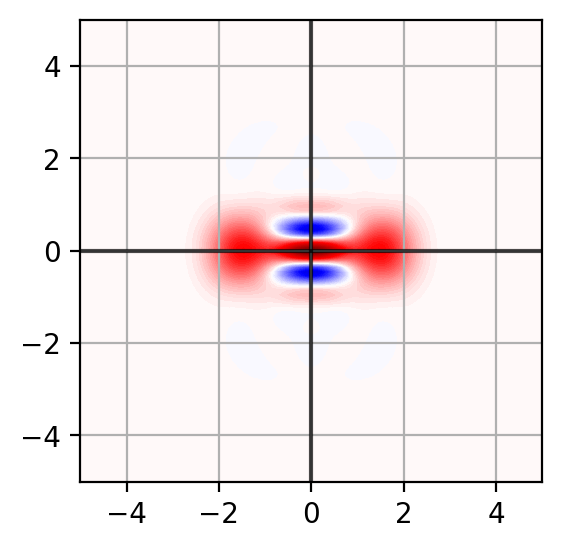

In [3]:
alpha = 1.5
cat_state = (jqt.coherent(10,alpha) + jqt.coherent(10,-alpha)).unit().to_dm()
pts = jnp.linspace(-5,5,100)
jqt.plot_wigner(cat_state, pts)

In [4]:
def cirq_full(params):
    N = 10
    initial_state = jqt.basis(2, 0) ^ jqt.basis(N, 0)
    reg = jqtc.Register([2,N])

    cirq = jqtc.Circuit.create(reg, layers=[])
    for i in range(params.shape[0]):
        cirq.append(jqtc.Rx(params[i][1]), 0)
        cirq.append(jqtc.Ry(params[i][2]), 0)
        cirq.append(jqtc.CD(N, params[i][0]), [0,1])

    res = jqtc.simulate(cirq, initial_state)
    return res[-1][0].ptrace(1)


def metric(params):
    alpha = 1.5
    cat_state = (jqt.coherent(10,alpha) + jqt.coherent(10,-alpha)).unit().to_dm()
    final_state = cirq_full(params) 
    return -jqt.overlap(final_state, cat_state)

metric_grad = jit(grad(metric))
# metric_vmap = vmap(metric)

# f = jit(metric_vmap)
# f_grad = jit(grad(metric_vmap))

In [5]:
key = jax.random.PRNGKey(1)
params = jax.random.normal(key, (5, 3))
metric_grad(params)

Array([[-3.91137657e-02, -6.93889390e-17,  1.38777878e-17],
       [ 1.29792713e-01, -1.05960875e-01,  4.13925609e-02],
       [ 1.47499984e-01,  6.56138221e-02,  4.01590330e-02],
       [-1.82501425e-01,  8.10261987e-02, -1.62930241e-02],
       [-5.37877340e-02, -2.42225303e-03, -5.17698946e-04]],      dtype=float64)

In [6]:
def optimize(params):
    start_learning_rate = 1e-1
    optimizer = optax.adam(start_learning_rate)

    # Initialize parameters of the model + optimizer.
    opt_state = optimizer.init(params)

    for _ in range(1000):
        grads = metric_grad(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
    
    return params

In [8]:
key = jax.random.PRNGKey(0)
params = jax.random.normal(key, (1, 5, 3))
optimal_params = optimize(params[0])
metric(optimal_params)

Array(-0.50597615, dtype=float64)